# Hands-on 02: Tabular data and BDTs: Classifying LHC collisions
## Goal
Discriminate $H\rightarrow \tau\tau$  (signal) from background such as $t\overline{t}$.

## XGBoost Tutorial

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

## Data
### Loading Data

In [7]:
! wget https://raw.githubusercontent.com/k-woodruff/bdt-tutorial/master/data/training_10k.csv -O data/training_10k.csv

--2025-02-13 20:57:15--  https://raw.githubusercontent.com/k-woodruff/bdt-tutorial/master/data/training_10k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2210243 (2.1M) [text/plain]
Saving to: ‘data/training_10k.csv’

data/training_10k.c 100%[===================>]   2.11M  12.3MB/s    in 0.2s    

2025-02-13 20:57:16 (12.3 MB/s) - ‘data/training_10k.csv’ saved [2210243/2210243]



In [8]:
data = pd.read_csv("data/training_10k.csv")

Seeing what the data looks like

In [9]:
print("Size of data: {}".format(data.shape))
print("Number of events: {}".format(data.shape[0]))
print("Number of columns: {}".format(data.shape[1]))

print("\nList of features in dataset:")
for col in data.columns:
    print(col)

Size of data: (10000, 33)
Number of events: 10000
Number of columns: 33

List of features in dataset:
EventId
DER_mass_MMC
DER_mass_transverse_met_lep
DER_mass_vis
DER_pt_h
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_deltar_tau_lep
DER_pt_tot
DER_sum_pt
DER_pt_ratio_lep_tau
DER_met_phi_centrality
DER_lep_eta_centrality
PRI_tau_pt
PRI_tau_eta
PRI_tau_phi
PRI_lep_pt
PRI_lep_eta
PRI_lep_phi
PRI_met
PRI_met_phi
PRI_met_sumet
PRI_jet_num
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi
PRI_jet_all_pt
Weight
Label


## Detailed description of features
Prefix-less variables `EventId`, `Weight`, and `Label` have a special role and should not be used as input to the classifier. The variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector, essentially the momenta of particles. Variables prefixed with DER (for DERived) are quantities computed from the primitive features. These quantities were selected by the physicists of ATLAS in the reference document either to select regions of interest or as features for the Boosted Decision Trees used in this analysis. In addition:

* Variables are floating point unless specified otherwise.

* All azimuthal $\phi$ angles are in radian in the $[-\pi, +\pi]$ range.

* Energy, mass, momentum are all in GeV

* All other variables are unitless.

* Variables are indicated as “may be undefined” when it can happen that they are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

* The mass of particles has not been provided, as it can safely be neglected for the Challenge.

Features:


The data set has 10,000 events with 33 columns each. The first column is an identifier, and should not be used as a feature. The last two columns Weight and Label, are the weights and labels from the simulation, and also should not be used as features (this information is all contained in the documentation).

Now we can look at how many events are signal and background:

In [10]:
# look at column labels --- notice last one is "Label" and first is "EventId" also "Weight"
print(f"Number of signal events: {len(data[data.Label == 's'])}")
print(f"Number of background events: {len(data[data.Label == 'b'])}")
print(f"Fraction signal: {len(data[data.Label == 's'])/(len(data[data.Label == 's']) + len(data[data.Label == 'b']))}")

Number of signal events: 3372
Number of background events: 6628
Fraction signal: 0.3372


## Visualizing the features

<Figure size 640x480 with 0 Axes>

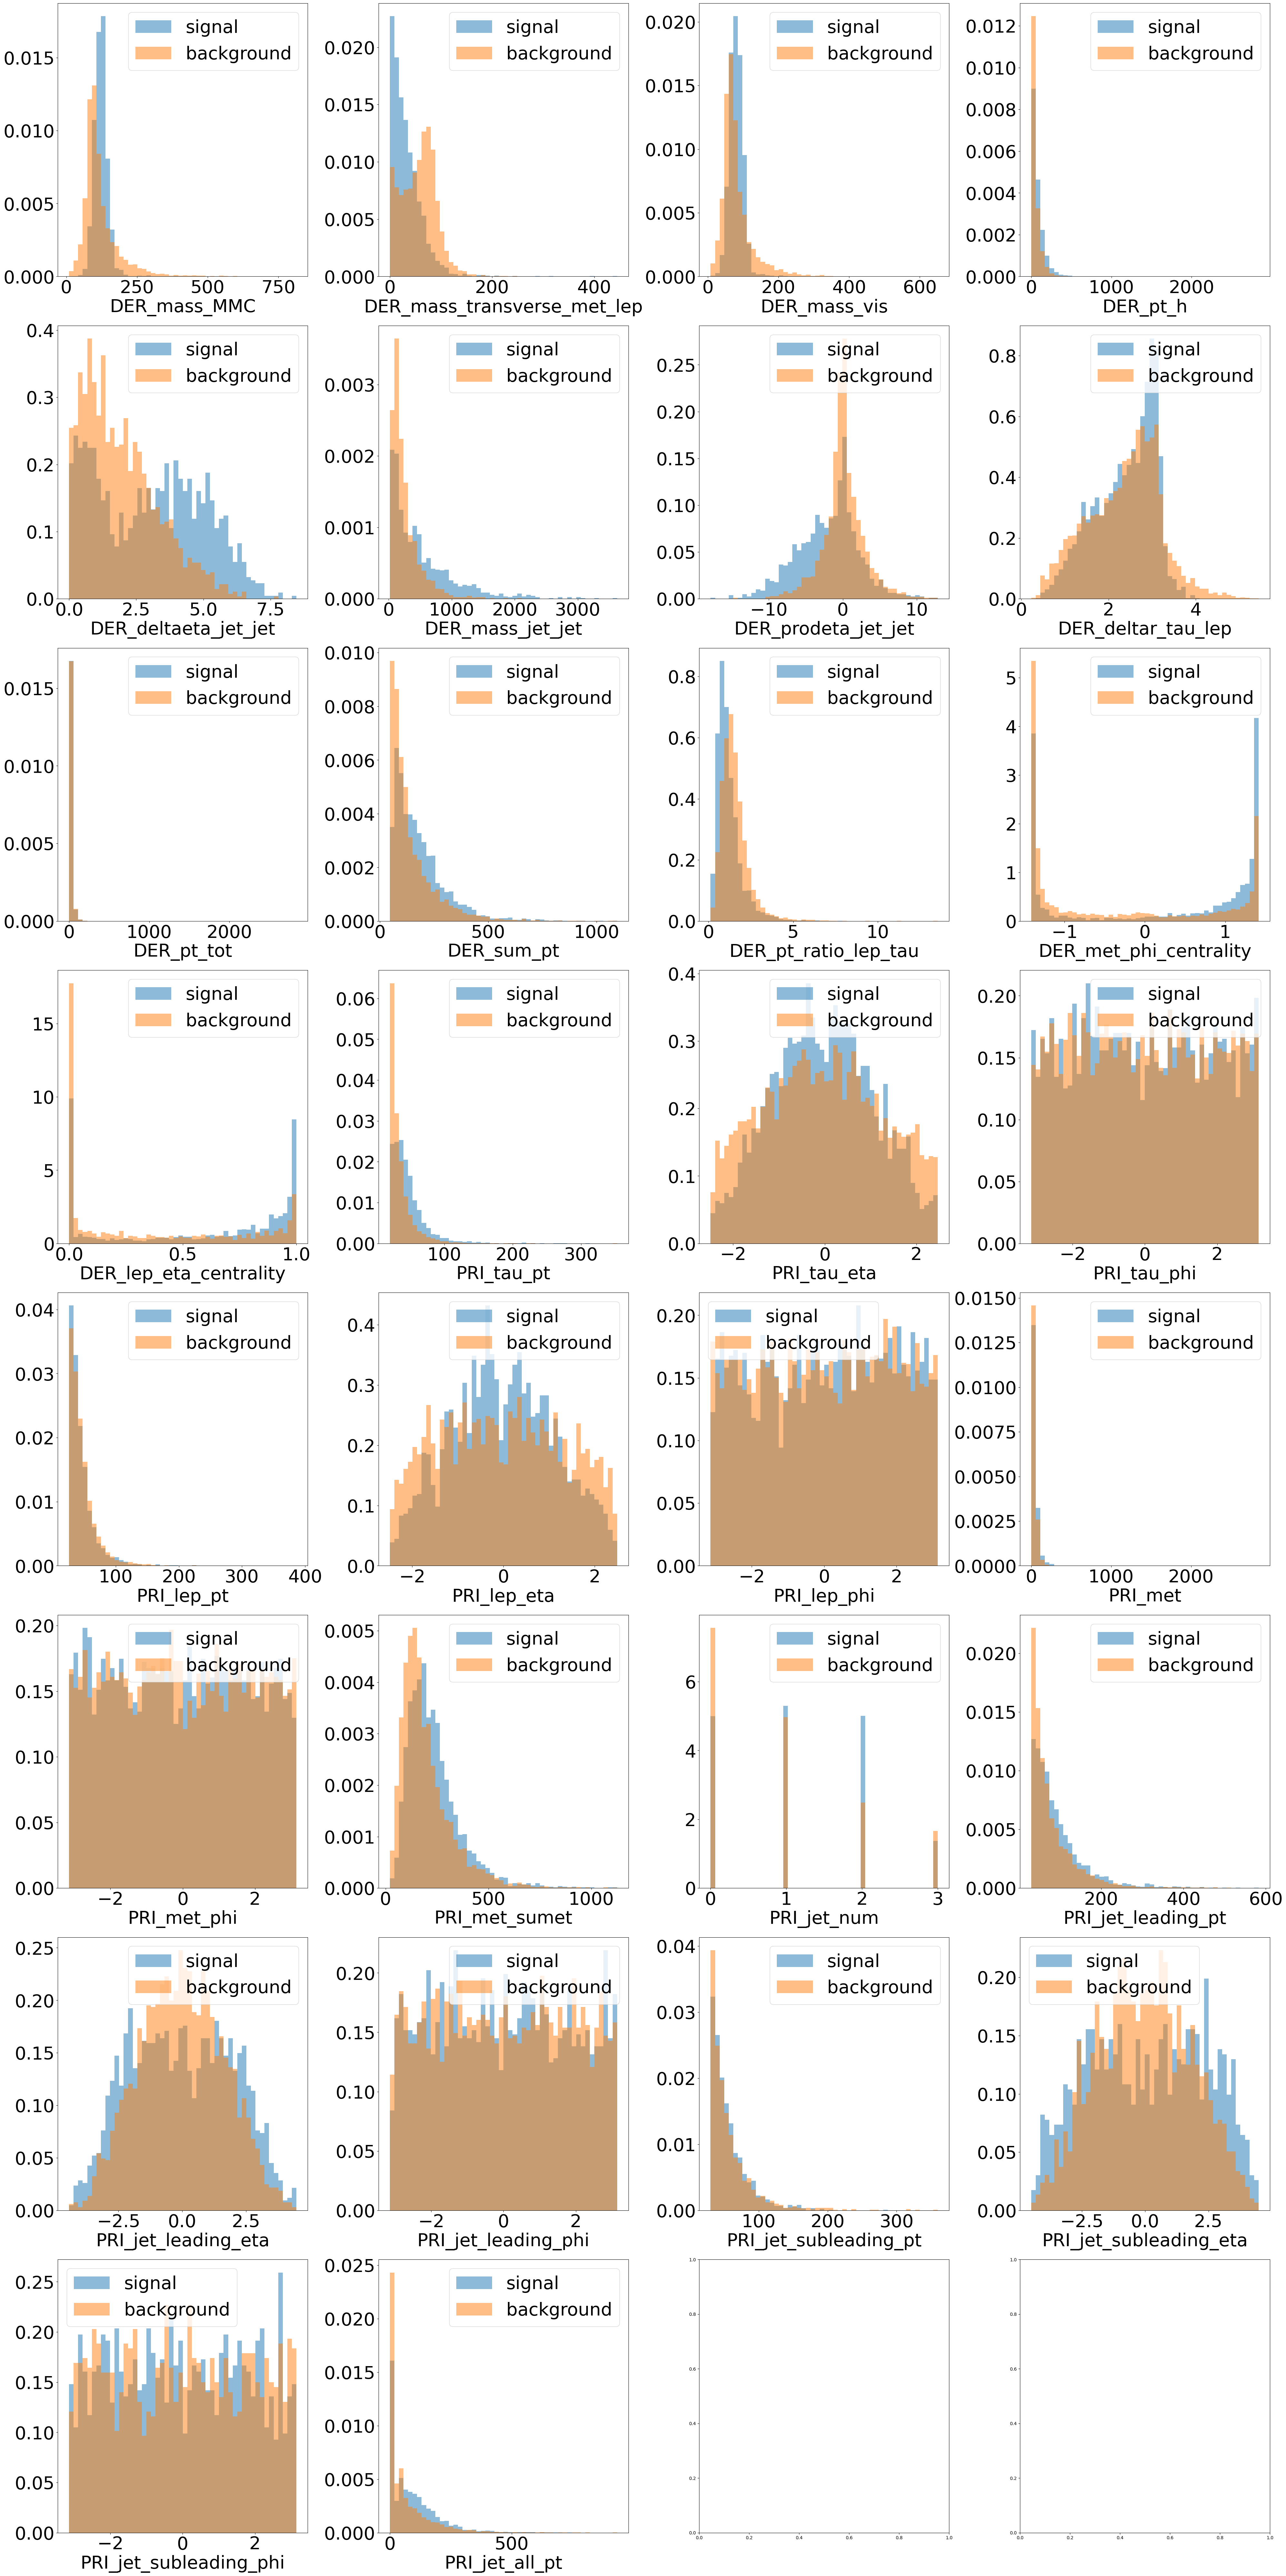

In [11]:
plt.figure()


fig, axs = plt.subplots(8, 4, figsize=(40, 80))

for ix, ax in enumerate(axs.reshape(-1)):
    col = data.columns[ix + 1]
    if col == "Weight" or col == "Label":
        continue
    signal = data[col][data.Label == "s"].to_numpy()
    mask_signal = signal > -999
    background = data[col][data.Label == "b"].to_numpy()
    mask_background = background > -999
    xmin = min(np.min(background[mask_background]), np.min(signal[mask_signal]))
    xmax = max(np.max(background[mask_background]), np.max(signal[mask_signal]))

    ax.hist(signal[mask_signal], bins=np.linspace(xmin, xmax, 51), alpha=0.5, label="signal", density=True)
    ax.hist(background[mask_background], bins=np.linspace(xmin, xmax, 51), alpha=0.5, label="background", density=True)

    ax.set_xlabel(col, fontsize=40)
    ax.set_xlabel(col, fontsize=40)
    ax.tick_params(axis="both", which="major", labelsize=40)
    ax.legend(fontsize=40)
plt.tight_layout()
plt.show()

## Format data:

Now we should get the data into an XGBoost-friendly format. We can create DMatrix objects that will be used to train the BDT model. For now, we’ll use all 30 of the features for training.

First, we’ll slice up the data into training and testing sets. Here, we take 20% for the test set, which is arbitrary.

In this file, all samples are independent and ordered randomly, so we can just grab a chunk. Check out Scikit-learn Cross-validation for dividing up samples responsibly.

We can also change the data type of the Label column to the Pandas type category for easier use later.

In [14]:
data["Label"] = data.Label.astype("category")

data_train = data[:8000]
data_test = data[8000:]

Check to make sure we did it right:

In [15]:
print(f"Number of training samples: {len(data_train)}")
print(f"Number of testing samples: {len(data_test)}")
print()
print(f"Number of signal events in training set: {len(data_train[data_train.Label == 's'])}")
print(f"Number of background events in training set: {len(data_train[data_train.Label == 'b'])}")
print(
    f"Fraction signal: {len(data_train[data_train.Label == 's'])/(len(data_train[data_train.Label == 's']) + len(data_train[data_train.Label == 'b']))}"
)

Number of training samples: 8000
Number of testing samples: 2000

Number of signal events in training set: 2688
Number of background events in training set: 5312
Fraction signal: 0.336


The `DMatrix` object takes as arguments:

  * `data`: the features

  * `label`: `1/0` or `True/False` for binary data (we have to convert our label to `boolean` from string `"s"/"b"`)

  * `missing`: how missing values are represented (here as `-999.0`)

  * `feature_names`: the names of all the features (optional)



In [ ]:
feature_names = list(data.columns[1:-2])  # we skip the first and last two columns because they are the ID, weight, and label
print(len(feature_names))

train = xgb.DMatrix(
    data=data_train[feature_names], label=data_train.Label.cat.codes, missing=-999.0, feature_names=feature_names
)
test = xgb.DMatrix(
    data=data_test[feature_names], label=data_test.Label.cat.codes, missing=-999.0, feature_names=feature_names
)

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']
30


Check if we did it right:

In [17]:
print(f"Number of training samples: {train.num_row()}")
print(f"Number of testing samples: {test.num_row()}")
print()
print(f"Number of signal events in training set: {len(np.where(train.get_label())[0])}")

Number of training samples: 8000
Number of testing samples: 2000

Number of signal events in training set: 2688


## Make the model
### Set hyperparameters:

The XGBoost hyperparameters are defined here. For a nice description of what they all mean, and tips on tuning them, see this guide.

In general, the tunable parameters in XGBoost are the ones you would see in other gradient boosting libraries. Here, they fall into three categories:

1. General parameters: e.g., which booster to use, number of threads. We won’t mess with these here.

1. Booster parameters: Tune the actual boosting, e.g., learning rate. These are the ones to optimize.

1. Learning task parameters: Define the objective function and the evaluation metrics.

Here, we will use the defaults for most parameters and just set a few to see how it’s done. The parameters are passed in as a dictionary or list of pairs.

Make the parameter dictionary:

In [18]:
param = {}

param["seed"] = 42  # set seed for reproducibility

# Booster parameters
param["eta"] = 0.1  # learning rate
param["max_depth"] = 10  # maximum depth of a tree
param["subsample"] = 0.8  # fraction of events to train tree on
param["colsample_bytree"] = 0.8  # fraction of features to train tree on

# Learning task parameters
param["objective"] = "binary:logistic"  # objective function
param["eval_metric"] = "error"  # evaluation metric for cross validation, note: last one is used for early stopping
param = list(param.items())

num_trees = 100  # number of trees to make

First, we set the booster parameters. Again, we just chose a few here to experiment with. These are the parameters to tune to optimize your model. Generally, there is a trade off between speed and accuracy.

  1. eta is the learning rate. It determines how much to change the data weights after each boosting iteration. The default is 0.3.

  1. max_depth is the maximum depth of any tree. The default is 6.

  1. subsample is the fraction of events used to train each new tree. These events are randomly sampled each iteration from the whole sample set. The default is 1 (use every event for each tree).

  1. colsample_bytree is the fraction of features available to train each new tree. These features are randomly sampled each iteration from the whole feature set. The default is 1.

Next, we set the learning objective to binary:logistic. So, we have two classes that we want to score from 0 to 1. The eval_metric parameters set what we want to monitor when doing cross validation. (We aren’t doing cross validation in this example, but we should be!) If you want to watch more than one metric, param must be a list of pairs, instead of a dict. Otherwise, we would just keep resetting the same parameter.

Last, we set the number of trees to 100. Usually, you would set this number high, and choose a cut off point based on the cross validation. The number of trees is the same as the number of iterations.

## Now Train

In [19]:
booster = xgb.train(param, train, num_boost_round=num_trees)

We now have a trained model. The next step is to look at it’s performance and try to improve the model if we need to. We can try to improve it by improving/adding features, adding more training data, using more boosting iterations, or tuning the hyperparameters (ideally in that order).

## Evaluate:
First, let’s look at how it does on the test set:

In [20]:
print(booster.eval(test))

[0]	eval-error:0.17849999999999999


These are the evaluation metrics that we stored in the parameter set.

It’s pretty hard to interpret the performance of a classifier from a few number. So, let’s look at the predictions for the entire test set.

In [21]:
predictions = booster.predict(test)
labels = test.get_label().astype(bool)

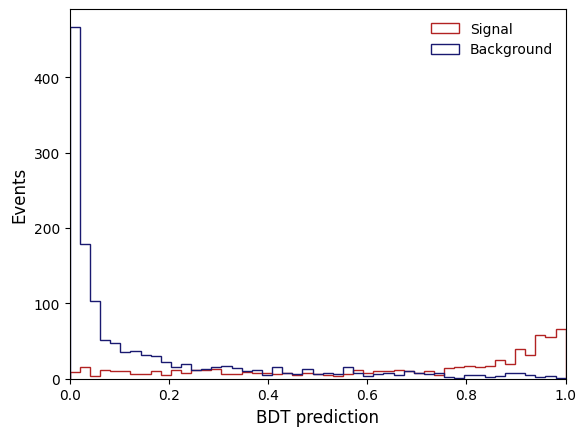

In [41]:
# plot signal and background predictions, separately
plt.figure()
plt.hist(predictions[labels], bins=np.linspace(0, 1, 50), histtype="step", color="firebrick", label="Signal")
plt.hist(predictions[~labels], bins=np.linspace(0, 1, 50), histtype="step", color="midnightblue", label="Background")
# make the plot readable
plt.xlabel("BDT prediction", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(frameon=False)
plt.xlim(0, 1)
plt.show()

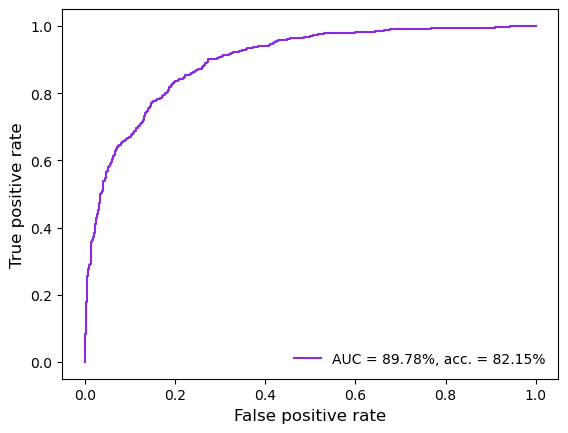

In [23]:
from sklearn.metrics import roc_curve, auc, accuracy_score

fpr, tpr, _ = roc_curve(labels, predictions)
auc_score = auc(fpr, tpr)
acc_score = accuracy_score(labels, predictions > 0.5)

# plot TPR vs. FPR (ROC curve)
plt.figure()
plt.plot(fpr, tpr, color="blueviolet", label=f"AUC = {auc_score*100:.2f}%, acc. = {acc_score*100:.2f}%")
# make the plot readable
plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.legend(frameon=False)
plt.show()

It’s also very informative to look at the importance of each feature. The “F score” is the number of times each feature is used to split the data over all the trees (times the weight of that tree).

There is a built-in function in the XGBoost Python API to easily plot this.

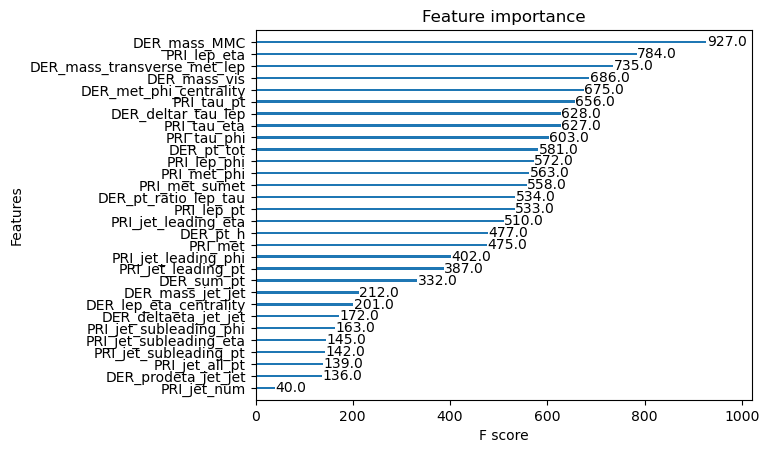

In [24]:
xgb.plot_importance(booster, grid=False)
plt.show()

The feature that was used the most was `DER_mass_MMC`.

We can plot how this feature is distributed for the signal and background.

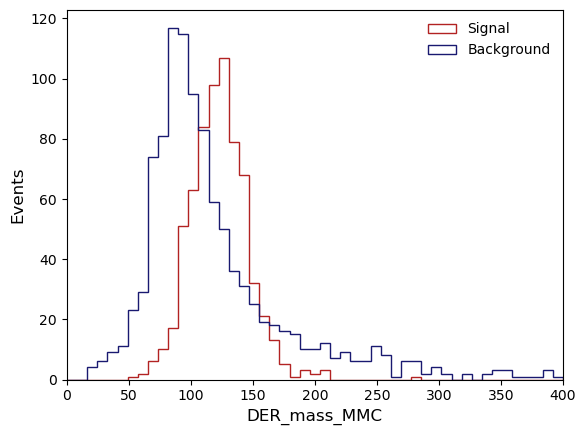

In [25]:
plt.figure()
plt.hist(
    data_test.DER_mass_MMC[data_test.Label == "s"],
    bins=np.linspace(0, 400, 50),
    histtype="step",
    color="firebrick",
    label="Signal",
)
plt.hist(
    data_test.DER_mass_MMC[data_test.Label == "b"],
    bins=np.linspace(0, 400, 50),
    histtype="step",
    color="midnightblue",
    label="Background",
)

plt.xlim(0, 400)
plt.xlabel("DER_mass_MMC", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(frameon=False)
plt.show()

This variable is physically significant because it represents an estimate of the Higgs boson mass. For signal, it is expected to peak at 125 GeV. We can also plot it with one of the next most important features DER_mass_transverse_met_lep. Note: the exact ranking of features can depend on the random seed and other hyperparameters.

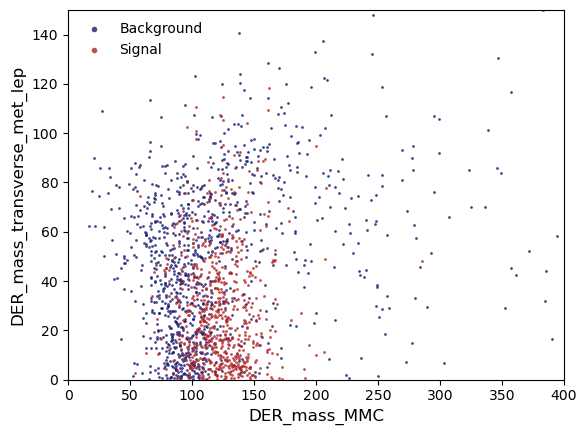

In [26]:
plt.figure()

mask_b = np.array(data_test.Label == "b")
mask_s = np.array(data_test.Label == "s")

DER_mass_MMC = np.array(data_test.DER_mass_MMC)
DER_mass_transverse_met_lep = np.array(data_test.DER_mass_transverse_met_lep)

plt.plot(
    DER_mass_MMC[mask_b],
    DER_mass_transverse_met_lep[mask_b],
    "o",
    markersize=2,
    color="midnightblue",
    markeredgewidth=0,
    alpha=0.8,
    label="Background",
)
plt.plot(
    DER_mass_MMC[mask_s],
    DER_mass_transverse_met_lep[mask_s],
    "o",
    markersize=2,
    color="firebrick",
    markeredgewidth=0,
    alpha=0.8,
    label="Signal",
)
plt.xlim(0, 400)
plt.ylim(0, 150)
plt.xlabel("DER_mass_MMC", fontsize=12)
plt.ylabel("DER_mass_transverse_met_lep", fontsize=12)
plt.legend(frameon=False, numpoints=1, markerscale=2)
plt.show()

# Exercise: Retrain BDT with 2 features and plot decision boundary

Repeat the steps above but manually set the features to just two of the most “important” ones: `feature_names = ["DER_mass_MMC", "DER_mass_transverse_met_lep"]`

Then use the code below to plot the decision boundary in 2D.

  1. What do you notice about the shape of the decision boundary?

  1. Do you see any evidence of overfitting? How can you prove it? (Hint: consider the training data

### Making new DMatrix objects with desired features


In [ ]:
feature_names =  ['DER_mass_MMC', 'DER_mass_transverse_met_lep'] # we skip the first and last two columns because they are the ID, weight, and label

train = xgb.DMatrix(
    data=data_train[feature_names], label=data_train.Label.cat.codes, missing=-999.0, feature_names=feature_names
)
test = xgb.DMatrix(
    data=data_test[feature_names], label=data_test.Label.cat.codes, missing=-999.0, feature_names=feature_names
)

2


## Restating hyperparameters of model and then training model

In [ ]:
param = {}

param["seed"] = 42  # set seed for reproducibility

# Booster parameters
param["eta"] = 0.1  # learning rate
param["max_depth"] = 10  # maximum depth of a tree
param["subsample"] = 0.8  # fraction of events to train tree on
param["colsample_bytree"] = 0.8  # fraction of features to train tree on

# Learning task parameters
param["objective"] = "binary:logistic"  # objective function
param["eval_metric"] = "error"  # evaluation metric for cross validation, note: last one is used for early stopping
param = list(param.items())

num_trees = 100  # number of trees to make


# training model
booster = xgb.train(param, train, num_boost_round=num_trees)



[0]	eval-error:0.22450000000000001


[0]	eval-error:0.22450000000000001


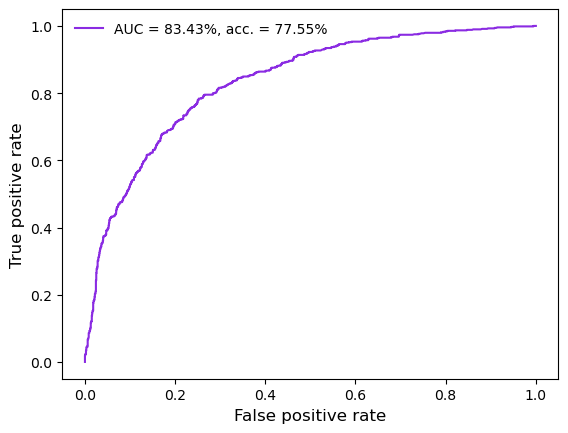

In [32]:
# evaluating
print(booster.eval(test))

predictions = booster.predict(test)
labels = test.get_label().astype(bool)
fpr, tpr, _ = roc_curve(labels, predictions)
auc_score = auc(fpr, tpr)
acc_score = accuracy_score(labels, predictions > 0.5)

# plot TPR vs. FPR (ROC curve)
plt.figure()
plt.plot(fpr, tpr, color="blueviolet", label=f"AUC = {auc_score*100:.2f}%, acc. = {acc_score*100:.2f}%")
# make the plot readable
plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.legend(frameon=False)
plt.show()


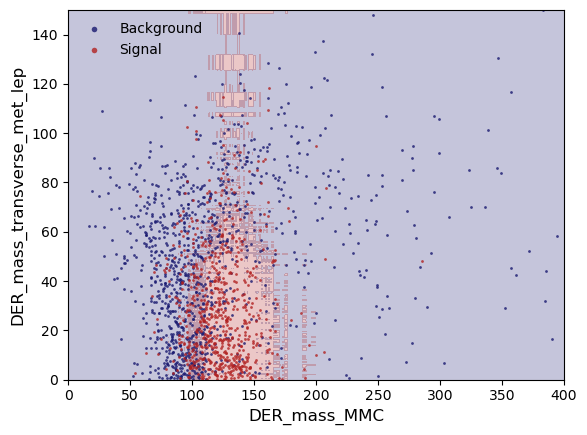

In [35]:
from matplotlib.colors import ListedColormap


# first get a mesh grid
x_grid, y_grid = np.meshgrid(np.linspace(0, 400, 1000), np.linspace(0, 150, 1000))
# convert grid into DMatrix
matrix_grid = xgb.DMatrix(
    data=np.c_[x_grid.ravel(), y_grid.ravel()], missing=-999.0, feature_names=feature_names
)
# run prediction for every value in grid
z_grid = booster.predict(matrix_grid)
# reshape
z_grid = z_grid.reshape(x_grid.shape)


plt.figure()
# plot decision boundary
ax = plt.subplot(111)
cm = ListedColormap(["midnightblue", "firebrick"])
plt.contourf(x_grid, y_grid, z_grid, levels=[0, 0.5, 1], cmap=cm, alpha=0.25)
# overlaid with test data points
plt.plot(
    DER_mass_MMC[mask_b],
    DER_mass_transverse_met_lep[mask_b],
    "o",
    markersize=2,
    color="midnightblue",
    markeredgewidth=0,
    alpha=0.8,
    label="Background",
)
plt.plot(
    DER_mass_MMC[mask_s],
    DER_mass_transverse_met_lep[mask_s],
    "o",
    markersize=2,
    color="firebrick",
    markeredgewidth=0,
    alpha=0.8,
    label="Signal",
)
ax.set_ylim(0,150)
ax.set_xlim(0,400)
plt.xlabel("DER_mass_MMC", fontsize=12)
plt.ylabel("DER_mass_transverse_met_lep", fontsize=12)
plt.legend(frameon=False, numpoints=1, markerscale=2)
plt.show()

We notice that the shape of the decission boundary is mostly around DER_mass_MMC=125, which 